# Análisis del modelo en búsqueda de patrones

## 1. Carga de librerías

In [1]:
# Se cargan las librerías necesarias
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.colors import ListedColormap
style.use('ggplot')
import seaborn as sns
import zipfile
import requests
from io import BytesIO
import calendar
import locale
from dateutil.relativedelta import relativedelta
from category_encoders import MEstimateEncoder
import re
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, normalize, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, classification_report, make_scorer, recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, ConfusionMatrixDisplay, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, auc
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import scipy.cluster.hierarchy as shc
from scipy.spatial import distance_matrix
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from scipy.stats import boxcox
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
#import tensorflow as tf
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as imbalanced_pipeline
import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 2. Preparación del modelo

In [2]:
# Se carga el conjunto de datos
df_accidentes = pd.read_csv('./Datasets/accidentes_limpio_v2.csv', delimiter=';', encoding='latin-1')
# Se quitan las columnas innecesaria
df_accidentes.drop(columns=['pmed_C30', 'pmed_URB', 'momento_dia_acc'], inplace=True)
# Se renombran las columnas
nombres_columnas = ['clase_via_acc', 'nombre_via_acc', 'numero_via_acc',
       'nom_distrito', 'nom_barrio', 'implicados', 'implicados_peatones',
       'implicados_pesados', 'implicados_turismos', 'implicados_motocicletas',
       'implicados_bicicletas', 'implicados_otros',
       'implicados_ligeros', 'lesividad', 'utm_x_acc', 'utm_y_acc',
       'prueba_droga_pos', 'intensidad_trafico', 'ocupacion_via', 'carga_via', 'vmed', 'cruce',
       'gravedad', 'año_acc', 'mes_acc', 'dia_semana_acc', 'dia_mes_acc', 'hora_acc',
       'tipo_accidente_alcance',
       'atropello_a_animal', 'caida',
       'choque_contra_obstaculo_fijo',
       'colision_frontal',
       'colision_fronto-lateral',
       'colisión_lateral', 'colision_multiple',
       'tipo_accidente_otro', 'solo_salida_de_la_via',
       'vuelco', 'cielo_despejado',
       'granizando', 'lluvia_intensa', 'lluvia_debil',
       'cielo_nublado', 'estado_meteo_desconocido', 'bicicleta_EPAC',
       'es_conductor', 'es_pasajero', 'sexo_desconocido', 'sexo_hombre', 
       'prueba_alcohol_pos', 'anillo_verde_ciclista', 'giros_y_sentidos',
       'ruta_no_ciclista', 'via_exclusiva_bici',
       'via_preferente_bici', 'via_uso_compartido', 'media_edad']

# Se aplica el cambio de nombre de las columnas
df_accidentes.columns = nombres_columnas

# Primero se ordenan los datos
df_accidentes = df_accidentes.sort_values(by=['año_acc', 'mes_acc', 'dia_mes_acc', 'hora_acc'],ignore_index=True)

# SEED 
SEED = 9

## 3. Entrenamiento del modelo

### 3.1. División de los datos

In [3]:
opción = 1
if opción == 1:
    # Se separan las variables de entrada y la target
    target = df_accidentes["gravedad"]
    variables = df_accidentes.drop(["gravedad","lesividad"], axis=1, inplace=False)

    # Proporción de división entre conjuntos de train y test
    train_ratio = 0.7  # 70% para train, 30% para test

    X_train, X_val, y_train, y_val = train_test_split(variables, target, train_size=train_ratio, shuffle=False, random_state=SEED)

else:
    # Alternativa a lo de arriba
    # O LO DE ARRIBA O LO DE ABAJO, LOS DOS, NO
    X = df_accidentes.drop(['gravedad','lesividad'], axis=1)
    y = df_accidentes['gravedad']

    sss = StratifiedKFold(n_splits=5, shuffle=False)

    for train_index, test_index in sss.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

# Examinamos la forma de los conjuntos de datos
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2744, 56), (1176, 56), (2744,), (1176,))

### 3.2. Definición de métricas

In [4]:
# Métrica que prioriza el recall de target = 1
recall_scorer = make_scorer(recall_score, pos_label=1)
f1_scorer = make_scorer(f1_score, pos_label=1)

# Define los porcentajes de recall deseados
target_recall_1 = 0.75
target_recall_0 = 0.75

# Define una función de pérdida para usar como base para la métrica personalizada
def custom_recall_loss(y_true, y_pred):
    recall_1 = recall_score(y_true, y_pred, pos_label=1)
    recall_0 = recall_score(y_true, y_pred, pos_label=0)
    loss = ((recall_1 - target_recall_1) ** 2) + ((recall_0 - target_recall_0) ** 2)
    return loss

# Crea una métrica personalizada utilizando make_scorer
custom_recall_scorer = make_scorer(custom_recall_loss, greater_is_better=False)

# Crea la métrica de recall de positivos
def tpr_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    return tpr

tpr_scorer = make_scorer(tpr_score)

def mi_metrica(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if tn /(tn + fp) > 0.7:
        calculo =  10 * tp / (tp + fn) + tn /(tn + fp)
    else:
        calculo = 2 * tp / (tp + fn) + tn /(tn + fp)
    return calculo

fjj_scorer = make_scorer(mi_metrica)

### 3.3. Definición de función de evaluación

In [5]:
# Se define una función para evaluar la clasificación
def evaluacion_clasificacion(modelo, nombre_modelo, X_val, y_val, proba=True, plot=True, show_print=True):
        # Evaluamos con los datos de validación
        y_pred = modelo.predict(X_val)
        if proba:
                y_pred_proba = modelo.predict_proba(X_val)[:, 1]
        

        if plot:
                fig, ax = plt.subplots(1, 2, figsize=(12, 5))

                fig.suptitle('Resultados ' + nombre_modelo, fontsize=14)

                # Confusion Matrix
                cm = confusion_matrix(y_val, y_pred)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(ax=ax[0], cmap='BuPu')
                ax[0].grid(False)
                ax[0].set_xlabel('Predicción')
                ax[0].set_ylabel('Original')
                ax[0].set_title('Matriz confusión', fontsize=12)

                if proba:

                        # ROC AUC 
                        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
                        roc_auc = auc(fpr, tpr)

                        ax[1].plot(fpr, tpr, color='darkorange', lw=2, 
                                label='ROC curve (area = %0.2f)' % roc_auc)
                        ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                        ax[1].set_xlim([0.0, 1.0])
                        ax[1].set_ylim([0.0, 1.05])
                        ax[1].set_xlabel('False Positive Rate')
                        ax[1].set_ylabel('True Positive Rate') 
                        ax[1].set_title('Receiver Operating Characteristic (ROC)', fontsize=12)
                        ax[1].legend(loc="lower right")

                plt.tight_layout()
                plt.show()

        if show_print:
                # Mostramos el classification report
                cr = pd.DataFrame(classification_report(y_val, modelo.predict(X_val), output_dict=True, zero_division=0))
                print(cr)

                print(f"-"*100)

                print(f"Recall total: {recall_score(y_val, y_pred, average='weighted'):.4f} || Clase 1: {recall_score(y_val, y_pred, pos_label=1):.4f} || Clase 0: {recall_score(y_val, y_pred, pos_label=0):.4f}")
                print(f"Precisión total: {precision_score(y_val, y_pred, average='weighted'):.4f} || Clase 1: {precision_score(y_val, y_pred, pos_label=1):.4f} || Clase 0: {precision_score(y_val, y_pred, pos_label=0):.4f}")
                print(f"F1 total: {f1_score(y_val, y_pred, average='weighted'):.4f} || Clase 1: {f1_score(y_val, y_pred, pos_label=1):.4f} || Clase 0: {f1_score(y_val, y_pred, pos_label=0):.4f}")
                print(f"ROC AUC: {roc_auc_score(y_val, y_pred):.4f}")

        return cr

In [6]:
# Se crea una lista para almacenar los resultados
resultados_list = []

### 3.4. Modelo de regresión logística

El mejor meta-parámetro encontrado: {'lr__C': 5, 'ovs__sampling_strategy': 0.2}
El mejor score es: -0.08214355293874402


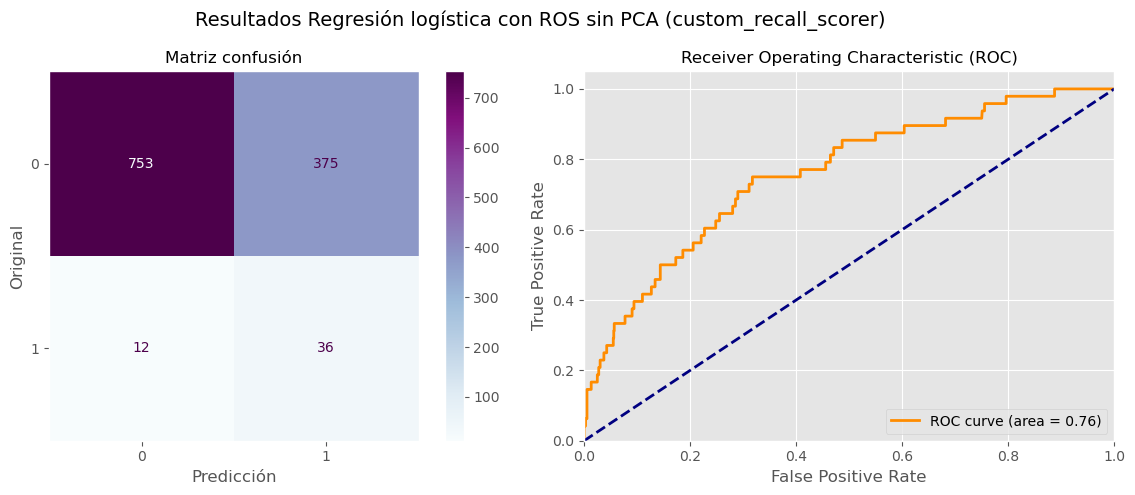

                     0          1  accuracy    macro avg  weighted avg
precision     0.984314   0.087591  0.670918     0.535952      0.947713
recall        0.667553   0.750000  0.670918     0.708777      0.670918
f1-score      0.795563   0.156863  0.670918     0.476213      0.769493
support    1128.000000  48.000000  0.670918  1176.000000   1176.000000
----------------------------------------------------------------------------------------------------
Recall total: 0.6709 || Clase 1: 0.7500 || Clase 0: 0.6676
Precisión total: 0.9477 || Clase 1: 0.0876 || Clase 0: 0.9843
F1 total: 0.7695 || Clase 1: 0.1569 || Clase 0: 0.7956
ROC AUC: 0.7088


In [194]:
metricas = [custom_recall_scorer] # recall_scorer, f1_scorer, 
nombres_metricas = ['custom_recall_scorer'] # 'recall_scorer', 'f1_scorer', 
titulo = 'Regresión logística con ROS sin PCA'

for metrica, nombre_metrica in zip(metricas, nombres_metricas):

    logr_ovs = imbalanced_pipeline([('std', StandardScaler()),
                                    ('ovs', RandomOverSampler(random_state=SEED)),
                                    ('std2', StandardScaler()),
                                    ('lr', LogisticRegression(C=1, penalty='l2', random_state=SEED, solver='newton-cg', class_weight='balanced', max_iter=5000))])

    # Se definen los meta-parámetros que se quieren optimizar con GridSearchCV.
    parameters = {
        'ovs__sampling_strategy': [0.1, 0.2, 0.5, 0.8, 1],
        'lr__C': [0.001, 0.01, 0.1, 1, 2, 5]
    }

    # Se aplica GridSearchCV para encontrar los mejores meta-parámetros
    grid_search_logr_ovs = GridSearchCV(logr_ovs, parameters, cv=5, n_jobs=-1, scoring=metrica) # recall_scorer, f1_scorer, custom_recall_scorer
    grid_search_logr_ovs.fit(X_train, y_train)

    # Se muestran por pantalla los mejores meta-parámetros encontrados
    print(f"El mejor meta-parámetro encontrado: {grid_search_logr_ovs.best_params_}")
    print(f"El mejor score es: {grid_search_logr_ovs.best_score_}")

    resultado = pd.DataFrame(evaluacion_clasificacion(grid_search_logr_ovs,  titulo + ' (' + nombre_metrica + ')', X_val, y_val, plot=True, show_print=True))
    resultado['modelo'] = titulo + ' (' + nombre_metrica + ')'
    resultados_list.append(resultado)

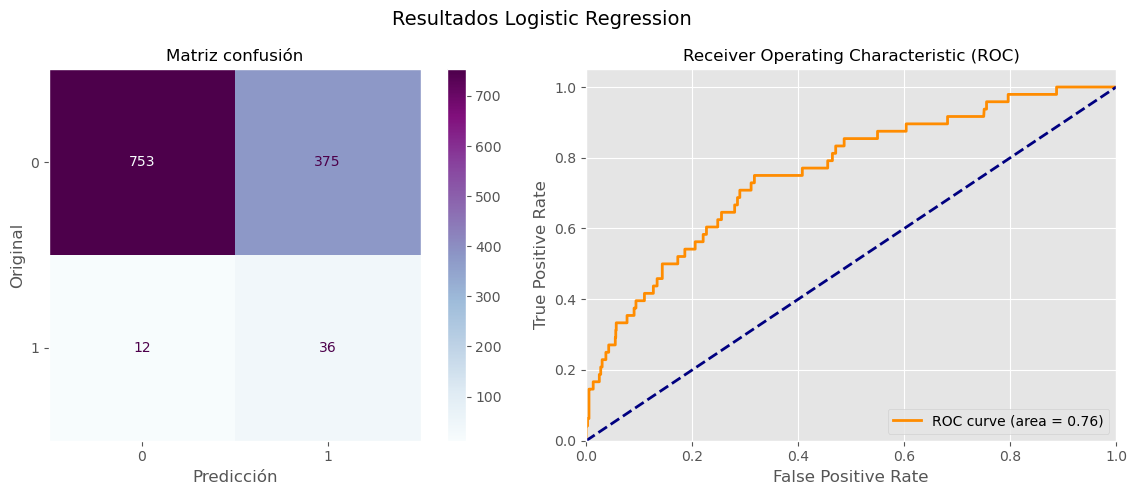

                     0          1  accuracy    macro avg  weighted avg
precision     0.984314   0.087591  0.670918     0.535952      0.947713
recall        0.667553   0.750000  0.670918     0.708777      0.670918
f1-score      0.795563   0.156863  0.670918     0.476213      0.769493
support    1128.000000  48.000000  0.670918  1176.000000   1176.000000
----------------------------------------------------------------------------------------------------
Recall total: 0.6709 || Clase 1: 0.7500 || Clase 0: 0.6676
Precisión total: 0.9477 || Clase 1: 0.0876 || Clase 0: 0.9843
F1 total: 0.7695 || Clase 1: 0.1569 || Clase 0: 0.7956
ROC AUC: 0.7088


,0,1,accuracy,macro avg,weighted avg
precision,0.984314,0.087591,0.670918,0.535952,0.947713
recall,0.667553,0.750000,0.670918,0.708777,0.670918
f1-score,0.795563,0.156863,0.670918,0.476213,0.769493
support,1128.000000,48.000000,0.670918,1176.000000,1176.000000


In [196]:
# Se crea el modelo simplificado de Logistic Regression
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns, index = X_train.index)

X_val_norm = scaler.transform(X_val)
X_val_norm = pd.DataFrame(X_val_norm, columns=X_val.columns , index = X_val.index)

ros = RandomOverSampler(random_state=SEED, sampling_strategy= 0.2)
X_train_res, y_train_res = ros.fit_resample(X_train_norm, y_train)

#
X_train_res = scaler.fit_transform(X_train_res)
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)

X_val_norm = scaler.transform(X_val_norm)
X_val_norm = pd.DataFrame(X_val_norm, columns=X_val.columns , index = X_val.index)
#

modelo_simp = LogisticRegression(C=5, penalty='l2', random_state=SEED, solver='newton-cg', class_weight='balanced', max_iter=5000)
modelo_simp.fit(X_train_res, y_train_res)

y_pred = pd.Series(modelo_simp.predict(X_val_norm), index = X_val_norm.index)
comparativa = pd.DataFrame({"Prediccion": y_pred, "Real": y_val})
comparativa['Indice2'] = comparativa.index - 2744

evaluacion_clasificacion(modelo_simp,  'Logistic Regression', X_val_norm, y_val, plot=True, show_print=True)

<Axes: ylabel='Feature'>

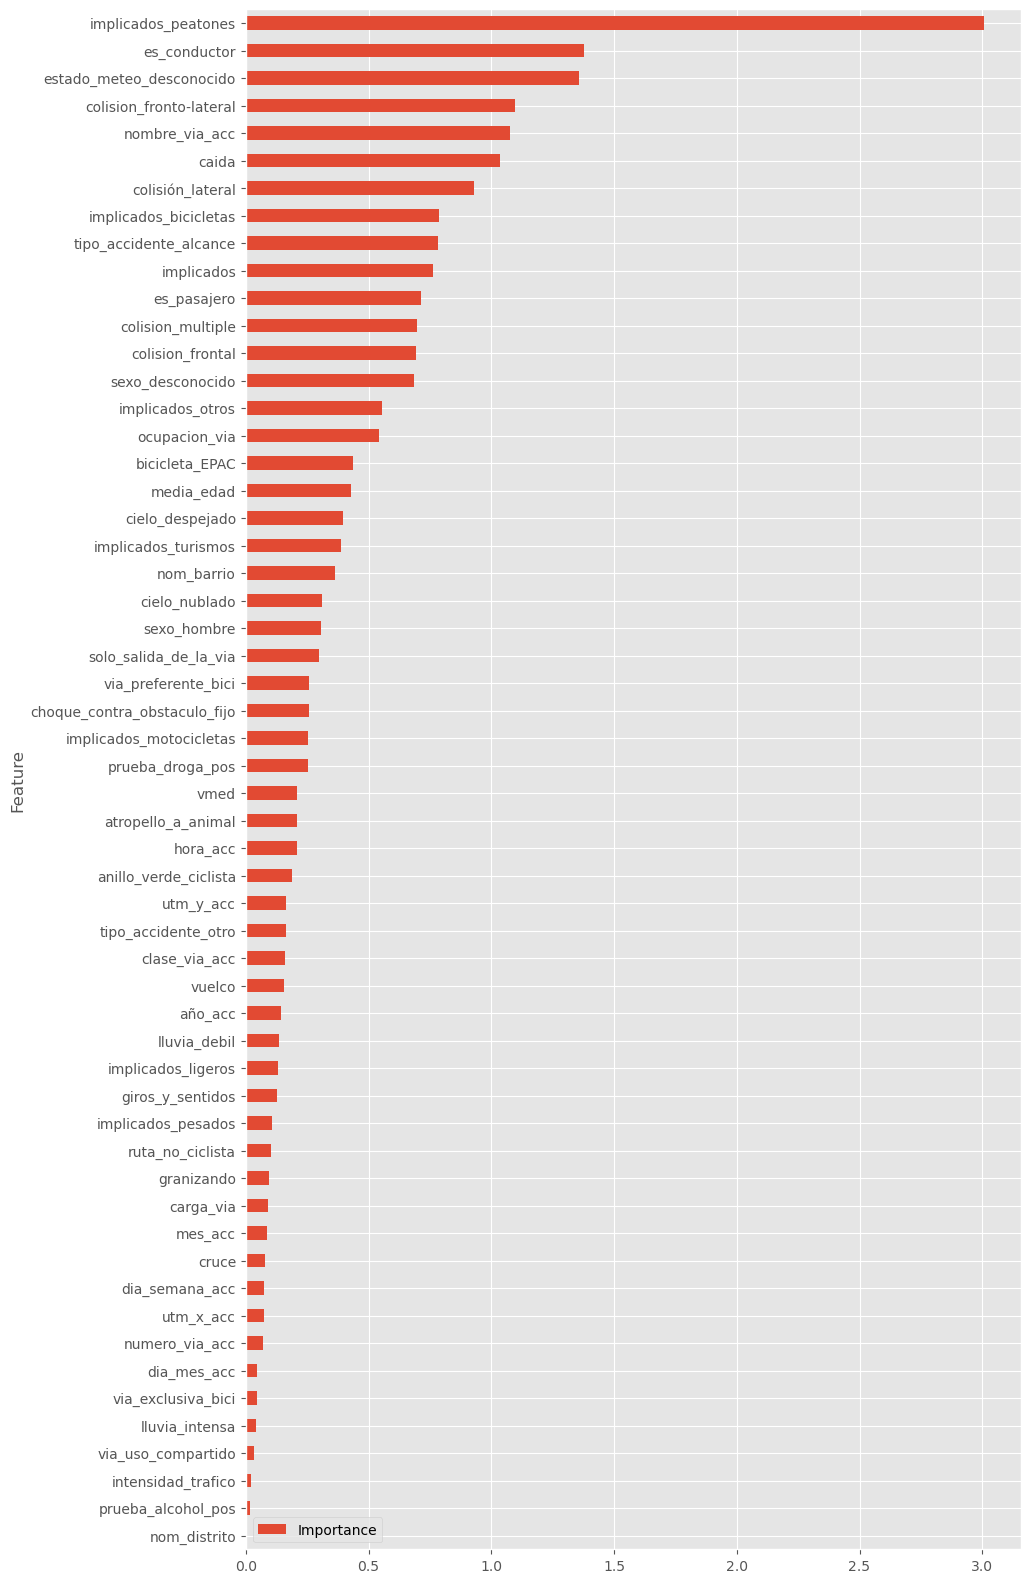

In [197]:
coefficients = modelo_simp.coef_[0]

feature_importance = pd.DataFrame({'Feature': modelo_simp.feature_names_in_, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 20))

Permutation importance

Fuente: https://forecastegy.com/posts/feature-importance-in-logistic-regression/

Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

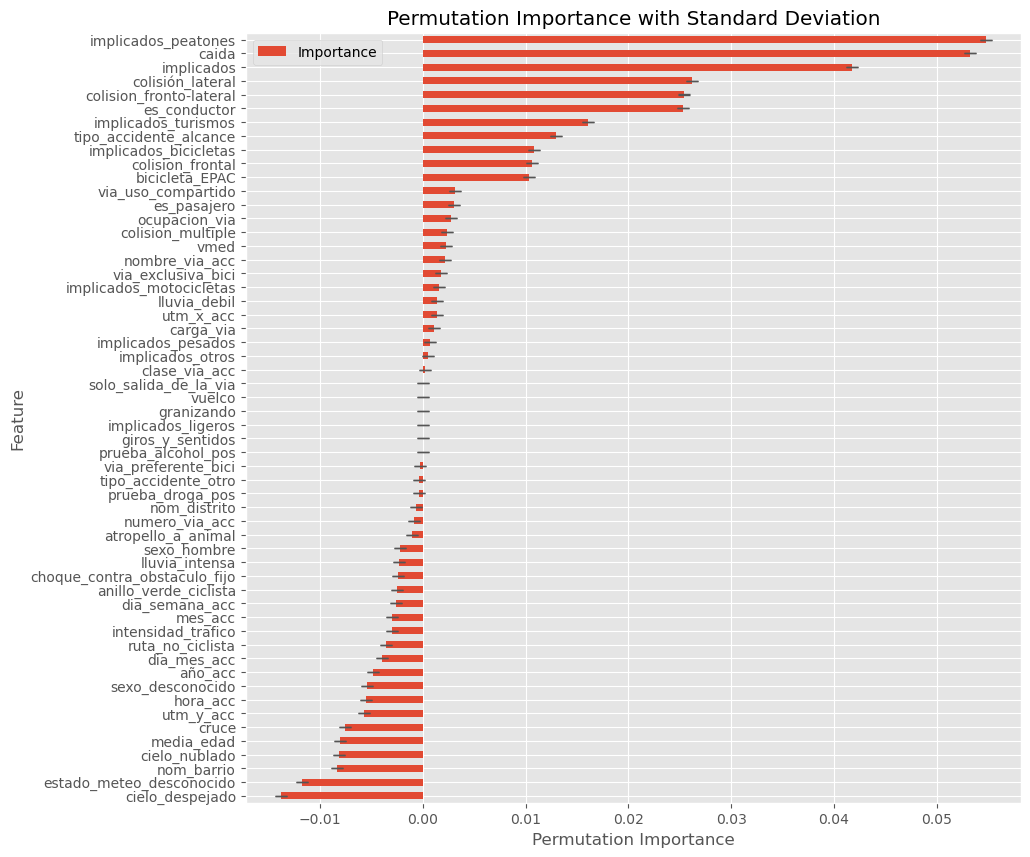

In [198]:
from sklearn.inspection import permutation_importance

result = permutation_importance(modelo_simp, X_val_norm, y_val, n_repeats=20, random_state=42)


feature_importance = pd.DataFrame({'Feature': X_val_norm.columns,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 10), yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')

In [199]:
features = pd.DataFrame( {'Coeficiente': modelo_simp.coef_[0]}, index = modelo_simp.feature_names_in_).sort_values(by='Coeficiente', ascending=False)

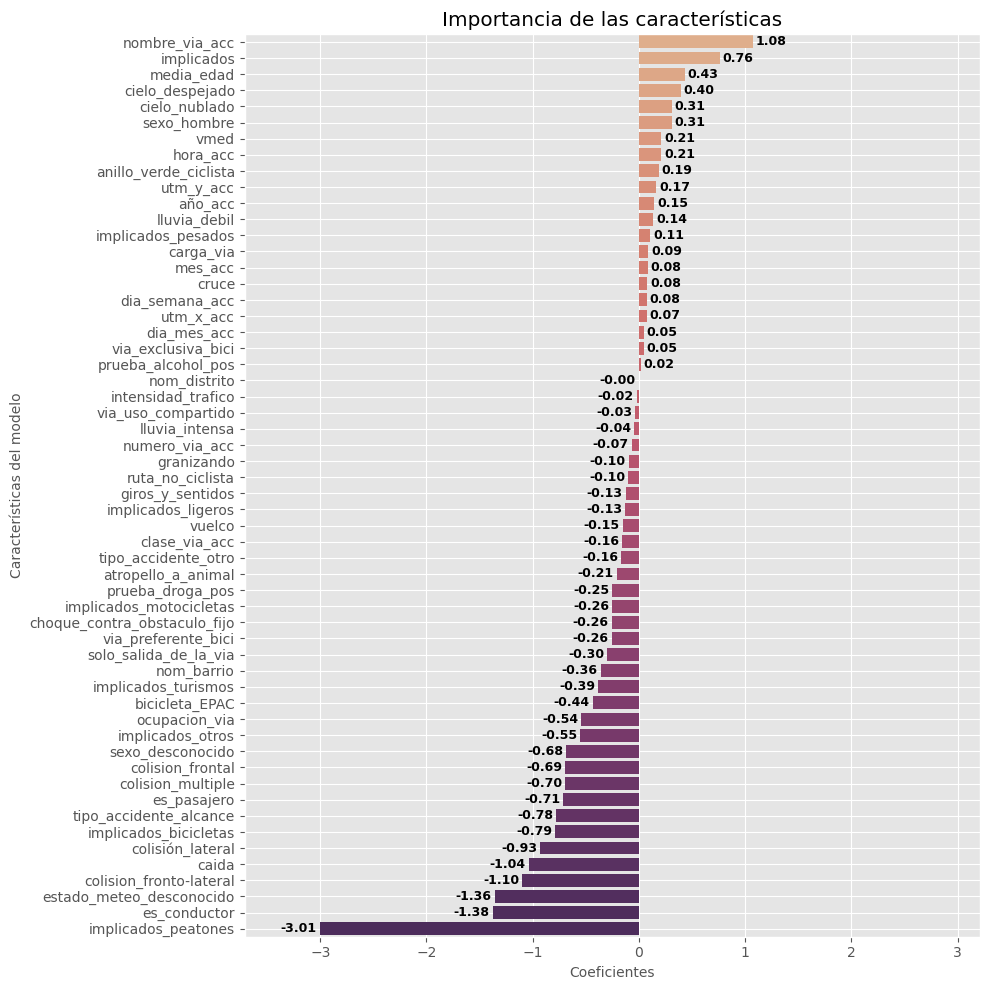

In [200]:
# Se seleccionan 

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=features, y=features.index, ax=ax, x='Coeficiente', palette='flare')
ax.bar_label(ax.containers[-1], fmt='%.2f', padding=2, fontsize=9, fontweight='bold') # default on top
xabs_max = abs(max(ax.get_xlim(), key=abs))
ax.set_xlim(xmin=-xabs_max-0.5, xmax=xabs_max)

plt.xlabel('Coeficientes', fontsize=10)
plt.ylabel('Características del modelo', fontsize=10)
plt.title('Importancia de las características')
plt.xticks(rotation=0)
plt.grid(True)

plt.tight_layout()
plt.show()

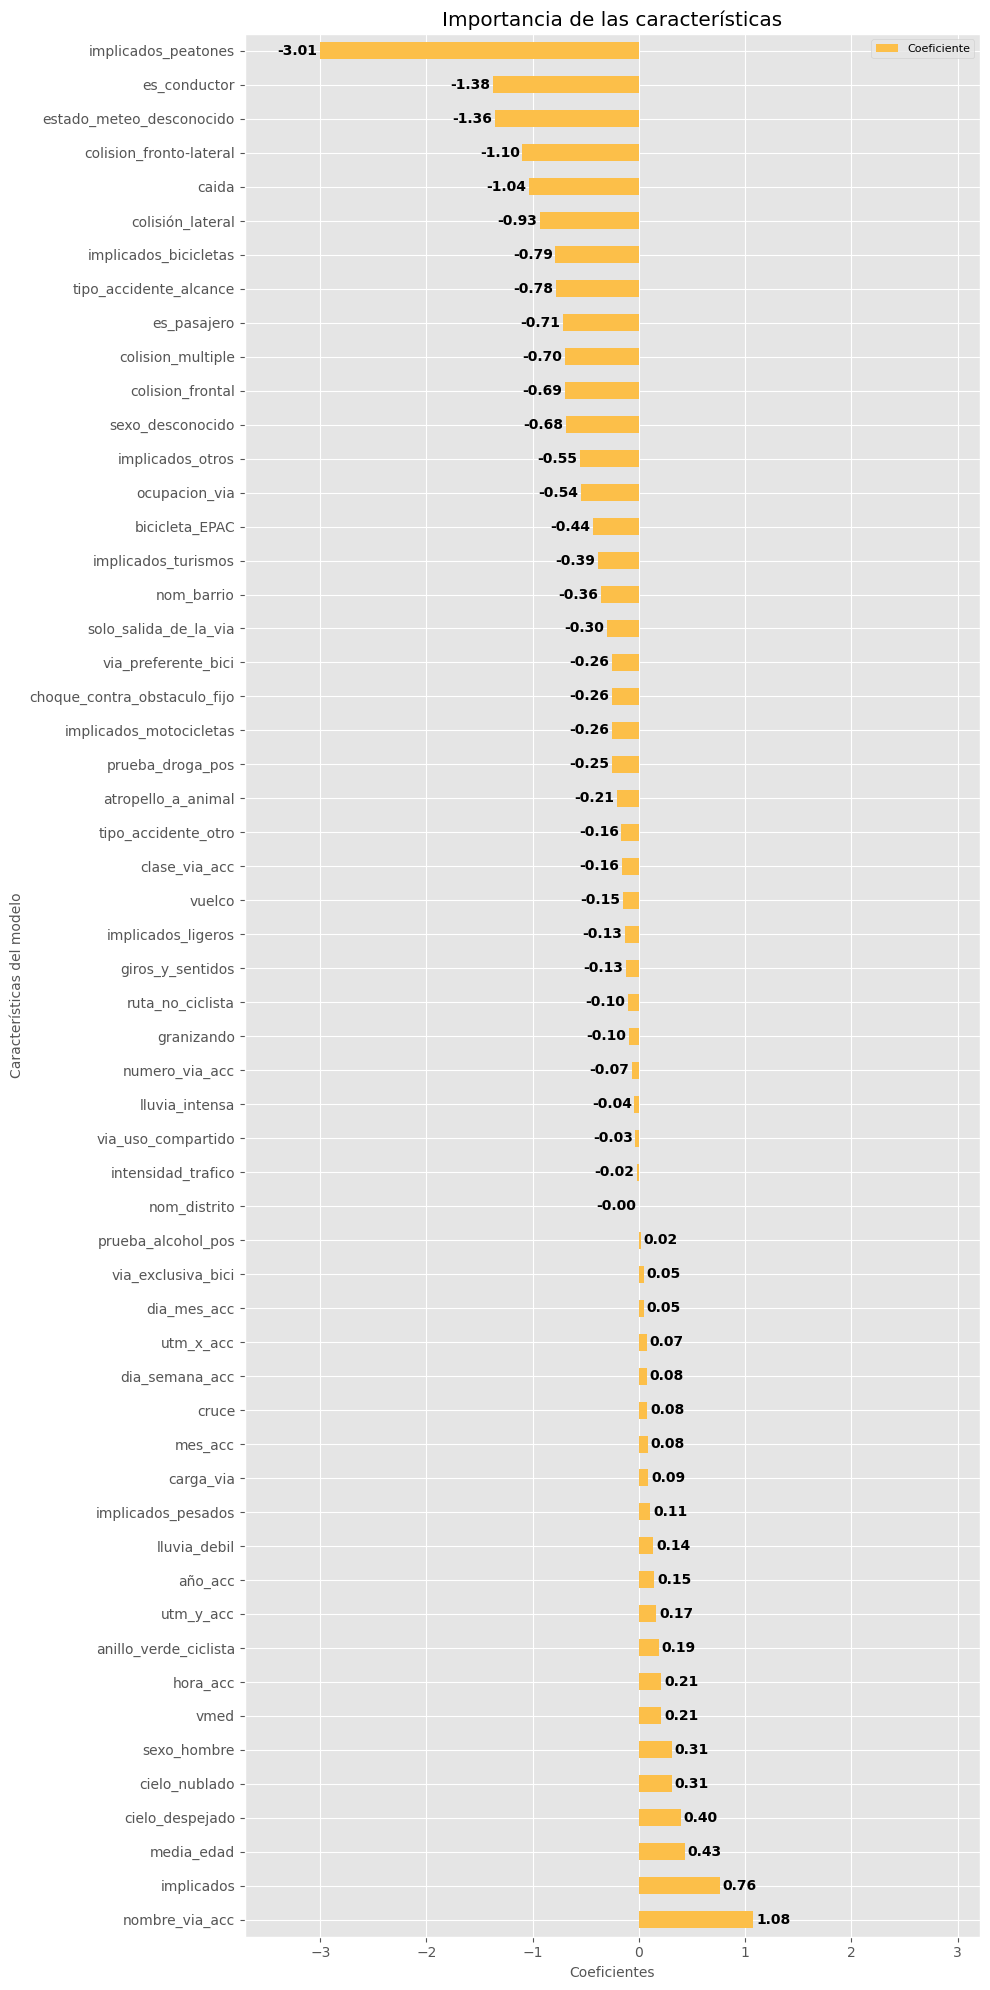

In [201]:
ax = features.plot.barh(figsize=(10, 20), color=['#fcbf49','#f77f00'])

ax.bar_label(ax.containers[-1], fmt='%.2f', padding=2, fontsize=10, fontweight='bold') # default on top

for bars in ax.containers:
    labels = [f"{bar.get_width():.0f}" if bar.get_width() > 25 else '' for bar in bars]
    ax.bar_label(bars, labels=labels, label_type='center', color='black', fontsize=10)

xabs_max = abs(max(ax.get_xlim(), key=abs))
ax.set_xlim(xmin=-xabs_max-0.5, xmax=xabs_max)

plt.xlabel('Coeficientes', fontsize=10)
plt.ylabel('Características del modelo', fontsize=10)
plt.title('Importancia de las características')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

### 3.5 SHAP values

In [202]:
explainer = shap.Explainer(modelo_simp, X_train_res, feature_names=modelo_simp.feature_names_in_)
shap_values = explainer(X_val_norm)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


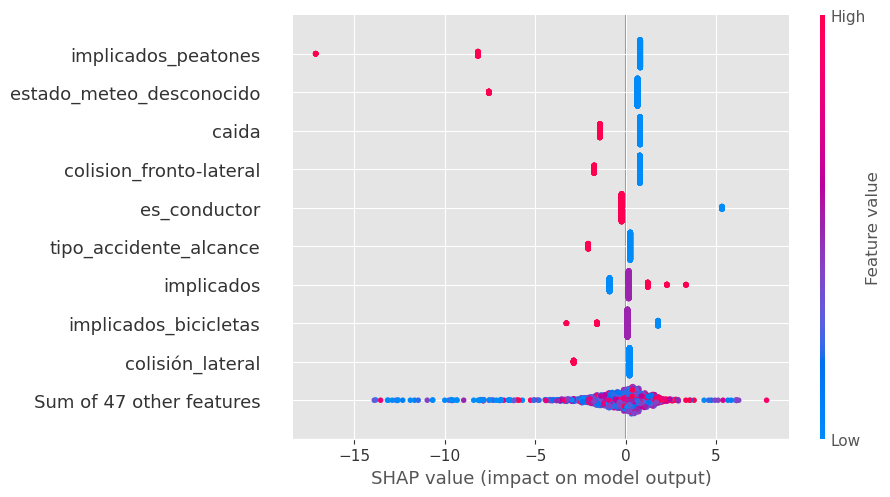

In [203]:
shap.plots.beeswarm(shap_values)

In [204]:
shap.initjs()
ind = 0
print(f"La predicción es de {comparativa.iloc[ind,:][0]} y lo real es {comparativa.iloc[ind,:][1]}")
shap.plots.force(shap_values[ind])


La predicción es de 0 y lo real es 0


In [205]:
shap.initjs()
ind = 8
print(f"La predicción es de {comparativa.iloc[ind,:][0]} y lo real es {comparativa.iloc[ind,:][1]}")
shap.plots.force(shap_values[ind])

La predicción es de 0 y lo real es 0


In [206]:
comparativa[(comparativa.Prediccion == 1) & (comparativa.Real ==1)].head()

,Prediccion,Real,Indice2
2747,1,1,3
2761,1,1,17
2772,1,1,28
2795,1,1,51
2807,1,1,63


In [207]:
comparativa[(comparativa.Prediccion == 0) & (comparativa.Real ==0)].head()

,Prediccion,Real,Indice2
2744,0,0,0
2745,0,0,1
2749,0,0,5
2750,0,0,6
2752,0,0,8
